# Исследование консольных игр

## Содержание
1. [Описание проекта](#step1)
2. [Изучение общей информации и подготовка данных](#step2)
3. [Исследовательский анализ данных](#step3)  
4. [Составление портрета пользователя каждого региона](#step4) 
5. [Проверка гипотез](#step5)
6. [Общий вывод](#step6)

<a id='step1'></a>

## 1. Описание проекта

**Задача** — выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  

**Данные:**  
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.  
Name — название игры  
Platform — платформа  
Year_of_Release — год выпуска  
Genre — жанр игры  
NA_sales — продажи в Северной Америке (миллионы проданных копий)  
EU_sales — продажи в Европе (миллионы проданных копий)  
JP_sales — продажи в Японии (миллионы проданных копий)  
Other_sales — продажи в других странах (миллионы проданных копий)  
Critic_Score — оценка критиков (максимум 100)  
User_Score — оценка пользователей (максимум 10)  
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.  
Данные за 2016 год могут быть неполными.  


[К содержанию](#Содержание)
<a id='step2'></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
%matplotlib inline

## 2. Изучение общей информации и подготовка данных

In [2]:
data = pd.read_csv('datasets/games.csv')
init_data = data.copy()

Для удобства работы с данными названия колонок приведём к нижнему регистру:

In [3]:
data.columns = data.columns.str.lower()

In [4]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Необходимо изменить тип данных для переменных `year_of_release` и `user_score`.  
Видно, что в данных довольно много пропущенных значений. Проведём уточняющий расчёт.

In [6]:
#функция для подсчёта пропущенных значений с учётом процентов от общей выборки
def missed_table(df):
    missed = df.isnull().sum()
    missed = missed[missed.values != 0] 
    missed_percent = (missed/len(df))*100 
    missed_percent = missed_percent.round(2) 
    missed_data = pd.concat([missed, missed_percent], axis=1)
    missed_data.columns = ['всего пропущено', '% от общей выборки']
    missed_data = missed_data.sort_values(by='% от общей выборки', ascending=False)
    return missed_data
missed_table(data)

,всего пропущено,% от общей выборки
critic_score,8578,51.32
rating,6766,40.48
user_score,6701,40.09
year_of_release,269,1.61
name,2,0.01
genre,2,0.01


Пропущенные значения переменных `year_of_release`, `name` и `genre` в совокупности составляют меньше 2% от выборки, так что их можно удалить.  
Рейтинг ESRB присваивается каждой игре на основе оценки контента, поэтому заполнение пропусков на основе рейтингов других игр было бы неправильным.   
Для прогноза оценок пользователей и критиков на основе имеющихся данных информации недостаточно, так что эти значения также оставим пропущенными.  

In [7]:
data = data.dropna(subset=['year_of_release', 'name', 'genre'])

В столбце `user_score` встречаются значения "tbd", что означает "to be determined" или "подлежит уточнению". Поскольку уточнить эти данные в рамках проекта возможности нет, будем рассматривать их как пропущенные значения.

In [8]:
data.loc[data['user_score']=='tbd', 'user_score'] = np.nan

В столбце `genre` встречаются значения "Misc", что означает "разное". Их также будем считать пропущенными, иначе "Misc" будет появляться в топах при оценке самых популярных жанров по регионам, а это неправильно.

In [9]:
data.loc[data['genre']=='Misc', 'genre'] = np.nan

Оценки пользователей переведём в числовой тип:

In [10]:
data['user_score'] = pd.to_numeric(data['user_score'])

Годы выпуска переведём в целочисленный тип:

In [11]:
data['year_of_release'] = data['year_of_release'].astype('int64')

Посмотрим на сводку данных:

In [12]:
data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000,7983.000000,7463.000000
mean,2006.486256,0.264012,0.145930,0.078487,0.047594,68.994363,7.126330
std,5.875525,0.818378,0.506716,0.311100,0.188005,13.920060,1.499447
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


Явных аномалий не наблюдается, данные выглядят правдоподобно.

Рассчитаем суммарные продажи во всех регионах:

In [13]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] +\
data['other_sales']

### Вывод
- тип данных переменной `year_of_release` переведён в целочисленный тип, переменной `user_score` - в десятичную дробь;
- строки с пропущенными значениями переменных `year_of_release`, `name` и `genre` удалены;
- значения 'tbd' переменной `user_score` и значения 'Misc' переменной `genre` будут рассматриваться как пропущенные;
- пропущенные значения переменных `critic_score`, `user_score` и `rating` оставлены;
- явных аномалий в данных не обнаружено;
- добавлен столбец с общими продажами по всем регионам `total_sales`.



[К содержанию](#Содержание)
<a id='step3'></a>

## 3. Исследовательский анализ данных

**Выбор актуального периода**

Посмотрим, сколько игр выпускалось в разные годы.  

In [14]:
games_released_by_years = data.groupby('year_of_release')['name'].count()

<a id='graph'></a>

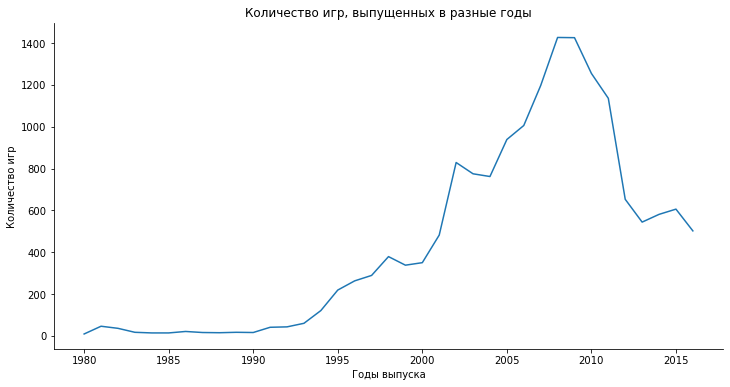

In [15]:
plt.title('Количество игр, выпущенных в разные годы')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax = games_released_by_years.plot(figsize=(12,6))
ax.set_xlabel('Годы выпуска')
ax.set_ylabel('Количество игр');

На графике видно, что рынок игр начинает значительно меняться примерно в 1993 году. Исключим из рассмотрения данные до 1994 года, когда выпускалось менее 100 игр в год.

In [16]:
data = data.query('year_of_release >= 1994')

Посмотрим на суммарные продажи по платформам.

In [17]:
grouped_by_platform = data.groupby('platform')['total_sales'].sum()
grouped_by_platform.sort_values(ascending=False)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       252.66
XB       251.57
N64      218.01
GC       196.73
XOne     159.32
GB       152.08
SNES      84.67
WiiU      82.19
PSV       53.81
SAT       33.59
DC        15.95
GEN        8.13
WS         1.42
NG         1.23
SCD        0.36
TG16       0.16
NES        0.11
3DO        0.10
PCFX       0.03
Name: total_sales, dtype: float64

PS2 лидирует по общим продажам с большим отрывом.


Рассчитаем для каждой платформы продажи и количество выпущенных игр по годам.

In [18]:
grouped_by_platform_and_year = data.pivot_table(
    index=['platform', 'year_of_release'], values='total_sales', aggfunc=['sum','count'])
grouped_by_platform_and_year.columns = ['total_sales', 'games_released']
grouped_by_platform_and_year

total_sales  games_released
platform year_of_release                             
3DO      1994                    0.02               1
         1995                    0.08               2
3DS      2011                   63.20             116
         2012                   51.36              93
         2013                   56.57              91
...                               ...             ...
XB       2008                    0.18               1
XOne     2013                   18.96              19
         2014                   54.07              61
         2015                   60.14              80
         2016                   26.15              87

[197 rows x 2 columns]

Рассмотрим подробнее топ-10 платформ по продажам.

In [19]:
top10_platforms = grouped_by_platform.sort_values(ascending=False).head(10)
top10_idx = top10_platforms.index

In [20]:
other_platforms = grouped_by_platform.sort_values(ascending=False).iloc[10:]
other_idx = other_platforms.index

In [21]:
top10_data = data.query('platform in @top10_idx')

In [22]:
years = top10_data['year_of_release'].unique()

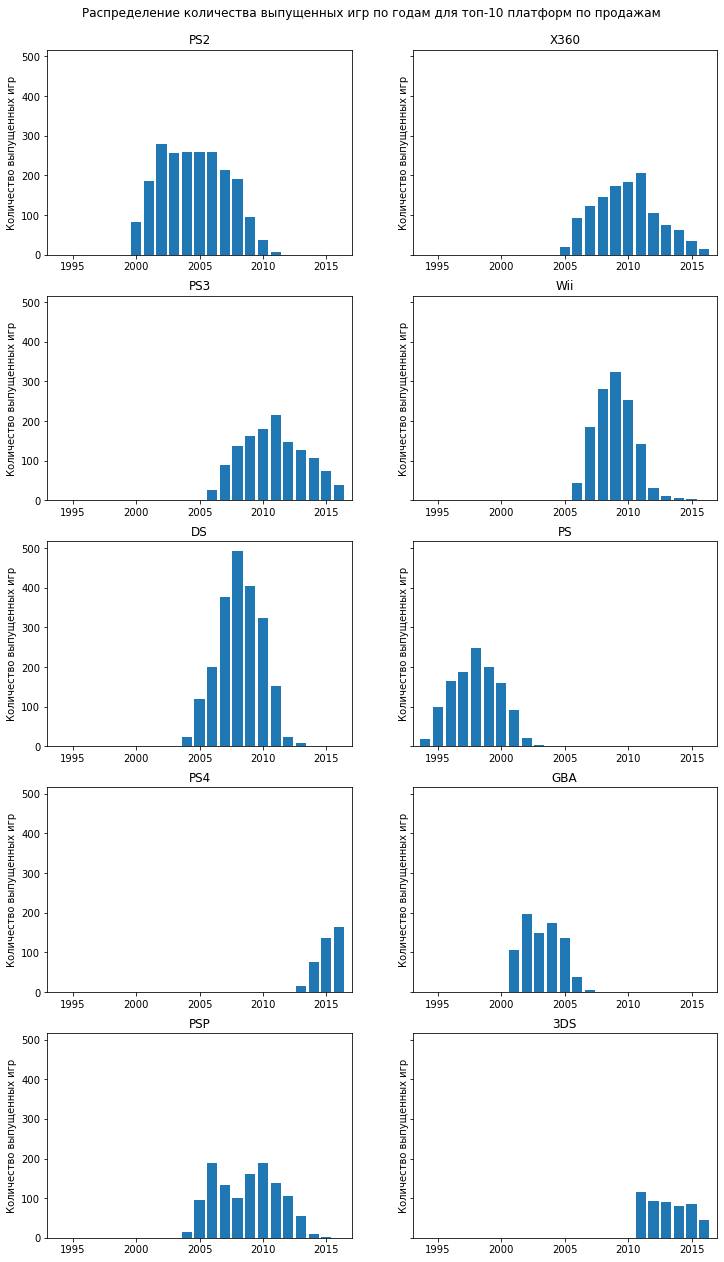

In [23]:
fig, axes = plt.subplots(5,2, figsize = (12,20), sharey=True)
for i, p in enumerate(top10_idx):
    platform = grouped_by_platform_and_year.loc[p, 'games_released']
    axes[i//2, i%2].set_xlim(years.min()-1, years.max()+1)
    axes[i//2, i%2].bar(platform.index, platform.values)
    axes[i//2, i%2].set_title(p)
    axes[i//2, i%2].set_ylabel('Количество выпущенных игр')
fig.suptitle(
    'Распределение количества выпущенных игр по годам для топ-10 платформ по продажам')
plt.subplots_adjust(top=0.95);

По графикам можно сделать вывод, что жизненный цикл большинства платформ составляет около 10 лет. 
Для некоторых платформ из топ-10 уже несколько лет не выпускаются игры.
По [графику](#graph) распределения общего числа игр по годам видно, что в районе 2010 года рынок консольных игр начинает падать: это можно объяснить как проблемами в мировой экономике в целом, так и серъёзными изменениями непосредственно в игровой индустрии. Примерно в это время мобильные игры и игры для планшетов составляют всё большую конкуренцию.  
Поэтому, думаю, для прогноза следует рассматривать данные от 2010 года и позднее.  


In [24]:
relevant_data = data.query('year_of_release>=2010')

In [25]:
relevant_total_sales = relevant_data.groupby('platform')[
    'total_sales'].sum().sort_values(ascending=False)
relevant_platforms = relevant_total_sales.index

**Выбор потенциально прибыльных платформ**

По суммарным продажам за актуальный период лидируют следующие платформы:

In [26]:
relevant_total_sales.head()

platform
PS3     587.74
X360    550.41
PS4     314.14
3DS     257.81
Wii     222.97
Name: total_sales, dtype: float64

In [27]:
r_grouped_by_platform_and_year = relevant_data.pivot_table(
    index=['platform', 'year_of_release'], values='total_sales', aggfunc=['sum','count'])
grouped_by_platform_and_year.columns = ['total_sales', 'games_released']
grouped_by_platform_and_year

total_sales  games_released
platform year_of_release                             
3DO      1994                    0.02               1
         1995                    0.08               2
3DS      2011                   63.20             116
         2012                   51.36              93
         2013                   56.57              91
...                               ...             ...
XB       2008                    0.18               1
XOne     2013                   18.96              19
         2014                   54.07              61
         2015                   60.14              80
         2016                   26.15              87

[197 rows x 2 columns]

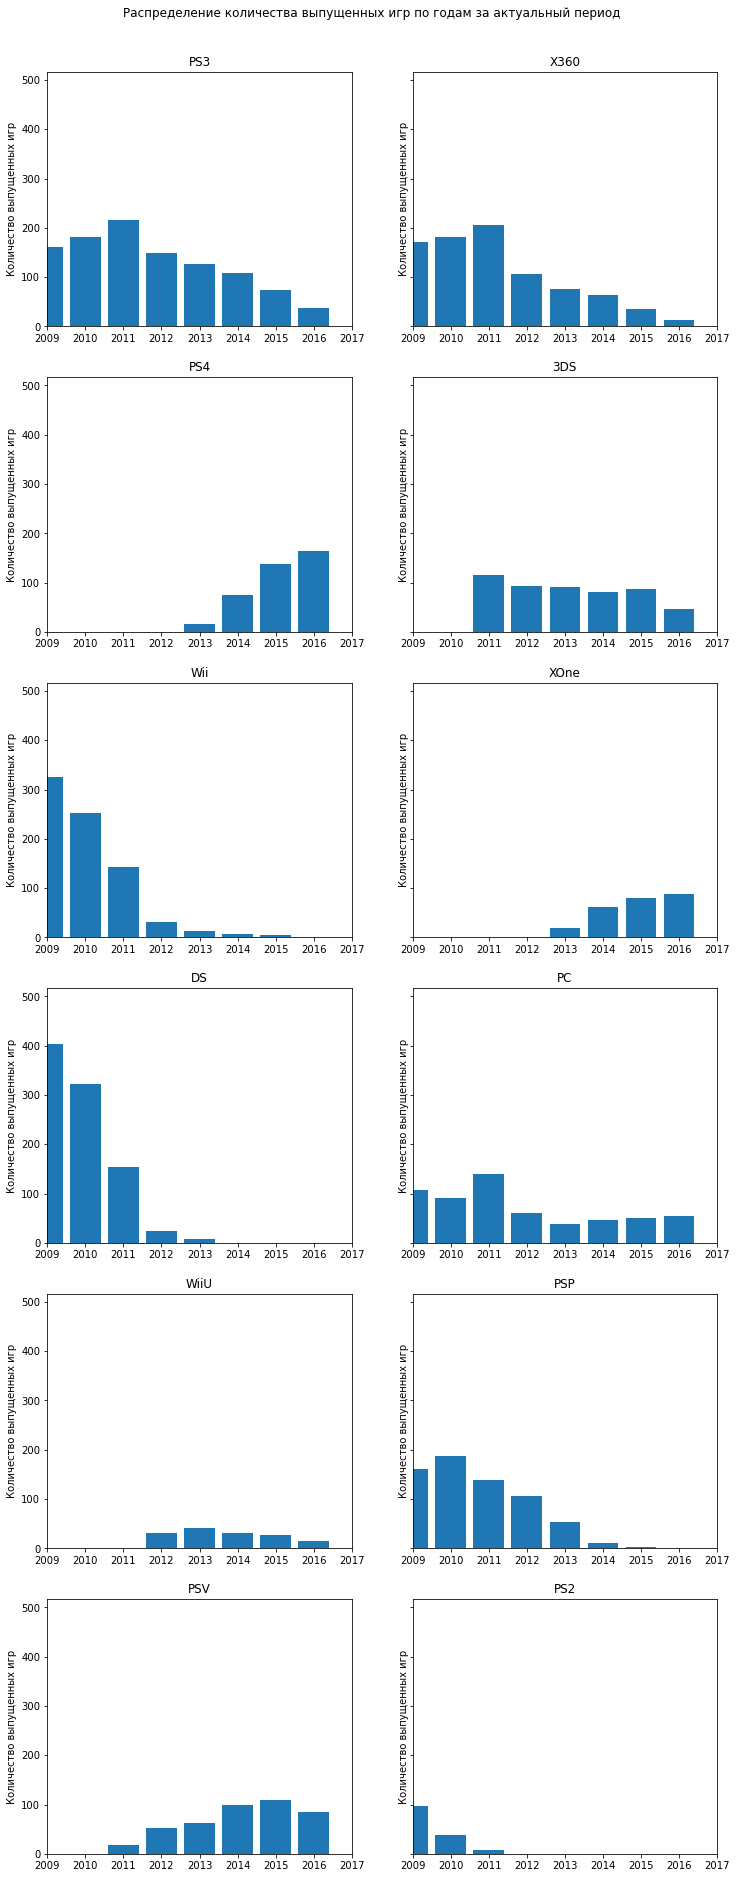

In [28]:
fig, axes = plt.subplots(6,2, figsize = (12,30), sharey=True)
for i, p in enumerate(relevant_platforms):
    platform = grouped_by_platform_and_year.loc[p, 'games_released']
    axes[i//2, i%2].set_xlim(2009, years.max()+1)
    axes[i//2, i%2].bar(platform.index, platform.values)
    axes[i//2, i%2].set_title(p)
    axes[i//2, i%2].set_ylabel('Количество выпущенных игр')
fig.suptitle(
    'Распределение количества выпущенных игр по годам за актуальный период')
plt.subplots_adjust(top=0.95);

Растут по продажам и являются перспективными:
- PS4 
- XOne
- PSV (наблюдается спад в 2016 году, но это скорее связано с тем, что данные за этот год могут быть неполными)  
- PC (продажи медленно, но растут)    

Также стоит принять во внимание платформу 3DS. Нельзя сказать, что продажи растут, но всё же наблюдается определённая стабильность (опять же учитывая, что данные за 2016 год неполные).  



In [29]:
prospective_platforms = ['PS4', 'XOne', 'PSV', 'PC', '3DS']

In [30]:
prospective_data = relevant_data.query('platform in @prospective_platforms')

In [31]:
grouped_prospective = prospective_data.groupby('platform')['total_sales'].sum()

In [32]:
data_list = [(platform, group_data) for (platform, group_data) in prospective_data.groupby(
    'platform')['total_sales']]

**Сравнение распределений продаж для выбранных перспективных платформ**

Построим диаграммы размаха по глобальным продажам для выбранных перспективных платформ.

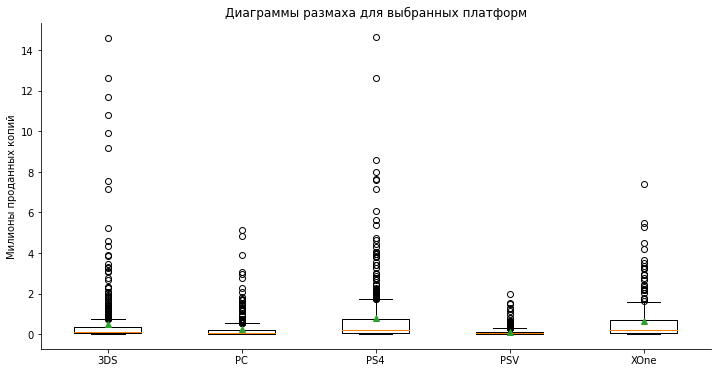

In [33]:
plt.figure(figsize=(12,6))
plt.title('Диаграммы размаха для выбранных платформ')
plt.ylabel('Милионы проданных копий')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.boxplot([d[1] for d in data_list], 
            labels=[d[0] for d in data_list],
           showmeans=True);

Распределения по глобальным продажам сильно скошены вправо и имеют мого выбросов.  
Наименьший разброс имеют продажи PSV.  
В целом, средние значения не превышают одного млн проданных копий, но заметно опережение PS4.  


In [34]:
prospective_data.groupby('platform')['total_sales'].mean().sort_values(
    ascending=False).round(2)

platform
PS4     0.80
XOne    0.65
3DS     0.50
PC      0.25
PSV     0.13
Name: total_sales, dtype: float64

У 3DS и PS4 есть наиболее далеко отстоящие выбросы. Интересно посмотреть, какие именно игры так хорошо продавались:

In [35]:
prospective_data.loc[prospective_data['total_sales']>=9, ['name', 'genre']]

,name,genre
31,Call of Duty: Black Ops 3,Shooter
33,Pokemon X/Pokemon Y,Role-Playing
40,Mario Kart 7,Racing
42,Grand Theft Auto V,Action
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,Role-Playing
53,Super Mario 3D Land,Platform
62,New Super Mario Bros. 2,Platform
73,Animal Crossing: New Leaf,Simulation


**Изучение влияния отзывов пользователей и критиков на продажи**

На уровне одной из перспективных платформ - PS4:

In [36]:
PS4_data = prospective_data[prospective_data['platform']=='PS4']

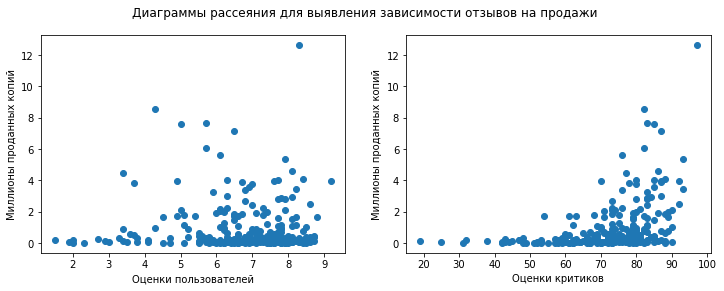

In [37]:
def sales_scores_relations(df):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].scatter(df.user_score, df.total_sales)
    axes[0].set_ylabel('Миллионы проданных копий')
    axes[0].set_xlabel('Оценки пользователей')
    axes[1].scatter(df.critic_score, df.total_sales)
    axes[1].set_ylabel('Миллионы проданных копий')
    axes[1].set_xlabel('Оценки критиков')
    fig.suptitle(
    'Диаграммы рассеяния для выявления зависимости отзывов на продажи');
sales_scores_relations(PS4_data)

Корреляции на уровне платформы PS4:

In [38]:
PS4_data[['user_score','critic_score', 'total_sales']].corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.557654,-0.031957
critic_score,0.557654,1.000000,0.406568
total_sales,-0.031957,0.406568,1.000000


На уровне выбранных перспективных платформ:

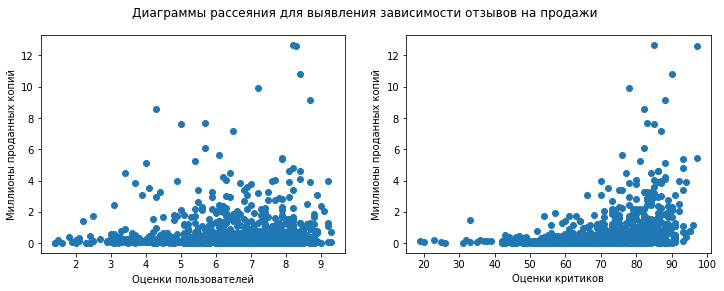

In [39]:
sales_scores_relations(prospective_data)

Корреляции на уровне выбранных перспективных платформ:

In [40]:
prospective_data[['user_score','critic_score', 'total_sales']].corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.504443,0.021549
critic_score,0.504443,1.000000,0.307708
total_sales,0.021549,0.307708,1.000000


Для других платформ:

In [41]:
other_data = relevant_data.query('platform not in @prospective_platforms')

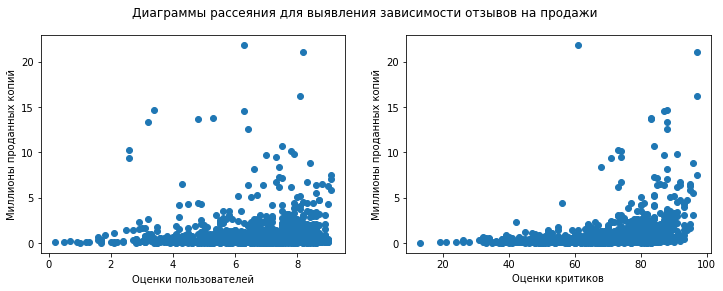

In [42]:
sales_scores_relations(other_data)

In [43]:
other_data[['user_score','critic_score', 'total_sales']].corr()

,user_score,critic_score,total_sales
user_score,1.000000,0.593917,0.079853
critic_score,0.593917,1.000000,0.348907
total_sales,0.079853,0.348907,1.000000


На всех уровнях корреляция между продажами и отзывами пользователей близка к нулю.  
Отзывам критиков покупатели, видимо, доверяют больше, причём максимальное значение коэффициент корреляции между продажами и оценками принимает у непопулярных платформ.  


**Изучение распределения игр по жанрам**

In [44]:
relevant_data[relevant_data['genre']!='Misc'].groupby('genre')['total_sales'].agg(['sum', 'count']).sort_values(
    by='sum', ascending=False)

,sum,count
genre,,
Action,673.09,1495
Shooter,479.74,410
Sports,328.39,575
Role-Playing,315.28,568
Racing,122.68,237
Platform,119.72,153
Fighting,81.59,199
Simulation,71.75,217
Adventure,61.00,563


 Игры жанра Action лидируют по продажам, причём таких игр и выпускается в три с половиной раза больше, чем игр второго по прибыльности жанра - Shooter.  
 Головоломки - Puzzle - на последнем месте. И по прибыльности, и по количеству.
 


[К содержанию](#Содержание)
<a id='step4'></a>

## 4. Составление портрета пользователя каждого региона

In [45]:
#Функция для выявления лидеров по определённому критерию по регионам
def top5(region, cat):
    sales = relevant_data.groupby(cat)[region].sum().sort_values(
        ascending=False)
    share = (sales/sum(sales)).round(2)
    table = pd.concat([sales, share], axis=1)
    table.columns = ['sum_sales','share']
    return table[:5]

**Cамые популярные платформы по регионам**

Северная Америка:

In [46]:
top5_platforms_na = top5('na_sales', 'platform')
top5_platforms_na

,sum_sales,share
platform,,
X360,334.18,0.30
PS3,229.25,0.20
Wii,121.20,0.11
PS4,108.74,0.10
XOne,93.12,0.08


Европа:

In [47]:
top5_platforms_eu = top5('eu_sales', 'platform')
top5_platforms_eu

,sum_sales,share
platform,,
PS3,213.60,0.25
X360,163.41,0.19
PS4,141.09,0.17
PC,68.82,0.08
Wii,65.91,0.08


Япония:

In [48]:
top5_platforms_jp = top5('jp_sales', 'platform')
top5_platforms_jp

,sum_sales,share
platform,,
3DS,100.62,0.33
PS3,59.26,0.19
PSP,42.20,0.14
DS,27.90,0.09
PSV,21.84,0.07


Другие страны:

In [49]:
top5_platforms_other = top5('other_sales', 'platform')
top5_platforms_other

,sum_sales,share
platform,,
PS3,85.63,0.32
PS4,48.35,0.18
X360,47.36,0.18
Wii,18.11,0.07
XOne,14.27,0.05


Сравним регионы по популярности платформ, а также сопоставим топы с тем списком платформ, которые мы выделили как перспективыне в ходе исследования.

In [50]:
top5_platforms_summary = pd.concat([pd.Series(prospective_platforms),
                                   pd.Series(top5_platforms_na.index),
                                   pd.Series(top5_platforms_eu.index),
                                   pd.Series(top5_platforms_jp.index),
                                   pd.Series(top5_platforms_other.index)], axis=1)
top5_platforms_summary.columns = ['prospective', 'na', 'eu', 'jp', 'other']
top5_platforms_summary.index = range(1,6)
top5_platforms_summary

,prospective,na,eu,jp,other
1,PS4,X360,PS3,3DS,PS3
2,XOne,PS3,X360,PS3,PS4
3,PSV,Wii,PS4,PSP,X360
4,PC,PS4,PC,DS,Wii
5,3DS,XOne,Wii,PSV,XOne


Во всех регионах была популярна платформа PS3, так что находящаяся на стадии роста PS4 в будущем, вероятно окажется на вершине топ-5.  
XOne входит в топ только в Северной Америке и прочих странах, PSV - только в Японии.  
Платформа PC остаётся популярной только в Европе.  
3DS популярна только в Японии, зато занимает в регионе первую строчку.

**Cамые популярные жанры по регионам**

In [51]:
top5('na_sales', 'genre')

,sum_sales,share
genre,,
Action,290.64,0.29
Shooter,237.47,0.24
Sports,156.81,0.16
Role-Playing,112.05,0.11
Platform,54.90,0.05


In [52]:
top5('eu_sales', 'genre')

,sum_sales,share
genre,,
Action,233.63,0.30
Shooter,171.45,0.22
Sports,116.84,0.15
Role-Playing,75.48,0.10
Racing,54.75,0.07


In [53]:
top5('jp_sales', 'genre')

,sum_sales,share
genre,,
Role-Playing,103.54,0.37
Action,72.20,0.26
Platform,15.81,0.06
Adventure,15.67,0.06
Sports,15.51,0.06


In [54]:
top5('other_sales', 'genre')

,sum_sales,share
genre,,
Action,76.62,0.31
Shooter,56.78,0.23
Sports,39.23,0.16
Role-Playing,24.21,0.10
Racing,15.14,0.06


Популярность жанров примерно одинакова во всех регионах, кроме Японии. Японцы явно недолюбливают "стрелялки", при этом гораздо больше, чем представители других регионов покупают ролевые игры.

**Влияние рейтинга ESRB на продажи в регонах**

In [55]:
esrb_na = relevant_data.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
esrb_eu = relevant_data.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
esrb_jp = relevant_data.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)
esrb_other = relevant_data.groupby('rating')['other_sales'].sum().sort_values(
    ascending=False)

In [56]:
esrb_summary = pd.concat([esrb_na, esrb_eu, esrb_jp, esrb_other], axis=1)
esrb_summary.columns=['na','eu','jp','other']
esrb_summary

,na,eu,jp,other
M,382.22,292.04,30.45,96.98
E,271.15,197.34,47.87,60.04
T,160.81,113.08,42.11,38.72
E10+,159.38,99.28,13.22,31.15
EC,1.13,0.00,0.00,0.07
RP,0.00,0.03,0.00,0.01


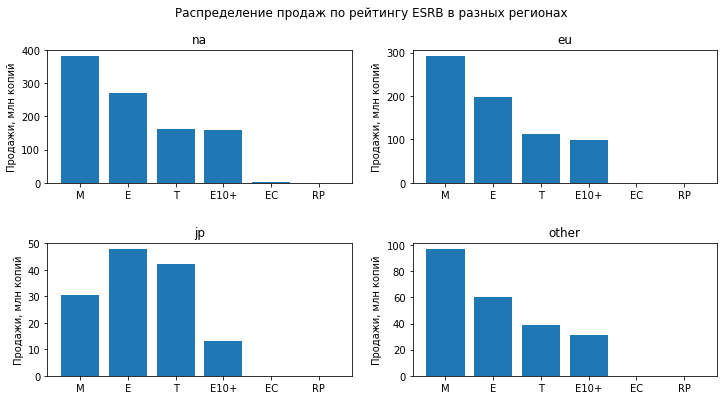

In [57]:
fig, axes = plt.subplots(2,2,figsize=(12,6))
fig.suptitle('Распределение продаж по рейтингу ESRB в разных регионах')
for i, r in enumerate(esrb_summary.columns):
    axes[i//2,i%2].bar(esrb_summary.index, esrb_summary[r])
    axes[i//2,i%2].set_title(r)
    axes[i//2,i%2].set_ylabel('Продажи, млн копий')
plt.subplots_adjust(hspace=0.45)

Тенденции примерно одинаковы во всех регионах, кроме Японии.  
В Японии больше покупают игр для всех (E или 6+) и для подростков (T  или 13+), в то время как в остальных регионах наиболее популярны игры для взрослых (M или 17+).


[К содержанию](#Содержание)
<a id='step5'></a>

## 5. Проверка гипотез

Поскольку в данном случае будут сравниваться средние значения, а распределение выборочного среднего, если в выборке достаточно наблюдений, распределено нормально, для проверки гипотез будем использовать T-критерий Стьюдента.  
Гипотезы сформулированы как двусторонние.  
Пороговое значение $\alpha$ принимаем равным 5%.  
Про дисперсии генеральных совокупностей ничего не известно, так что принимаем параметр `equal_var=False`.

In [58]:
alpha = .05

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Нулевая гипотеза $H_0$: cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.
Альтернативная гипотеза $H_1$: cредние пользовательские рейтинги платформ Xbox One и PC отличаются.  

In [59]:
data_for_test = relevant_data.dropna(subset=['user_score'])

In [60]:
results1 = st.ttest_ind(data_for_test.loc[data_for_test['platform']=='XOne', 'user_score'],
             data_for_test.loc[data_for_test['platform']=='PC', 'user_score'],
             equal_var=False)

In [61]:
if results1.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
    print('Пользовательские рейтинги платформ Xbox One и PC отличаются.')
else:
    print('Нулевая гипотеза не отвергается.')
    print('Пользовательские рейтинги платформ Xbox One и PC не отличаются.')

Нулевая гипотеза не отвергается.
Пользовательские рейтинги платформ Xbox One и PC не отличаются.


2. Средние пользовательские рейтинги жанров Action и Sports разные.

In [62]:
results2 = st.ttest_ind(data_for_test.loc[data_for_test['genre']=='Action', 'user_score'],
             data_for_test.loc[data_for_test['genre']=='Sports', 'user_score'],
             equal_var=False)

In [63]:
if results2.pvalue < alpha:
    print('Нулевая гипотеза отвергается.')
    print('Пользовательские рейтинги жанров Action и Sports разные.')
else:
    print('Нулевая гипотеза не отвергается.')
    print('Пользовательские рейтинги жанров Action и Sports не отличаются.')

Нулевая гипотеза отвергается.
Пользовательские рейтинги жанров Action и Sports разные.


[К содержанию](#Содержание)
<a id='step6'></a>

## 6. Общий вывод

- В качестве актуального периода в исследовании рассматривался временной отрезок от 2010 года и позднее;  
- Перспективными решено считать платформы:  
 - PS4  
 - XOne  
 - PSV  
 - PC  
 - DS  
- PS4 находится в фазе роста и имеет наибольшее среднее значение глобальных продаж среди выбранных перспективных платформ;  
- Оценки пользователей не влияют на продажи, в отличие от оценок критиков;  
- Самые популярные глобально жанры:  
  - Action  
  - Shooter  
  - Sports  
  - Role-Playing
  - Racing
- Популярность платформ отличается по регионам. Если PS4 будет популярна везде, то PC входит в топ 5 только в Европе, XOne - В Северной Америке и прочих странах, 3DS и PSV - только в Японии, причём 3DS - на первой строчке топ 5 в регионе.  
- В целом, Японию следует рассматривать как особый регион: она отличается от остальных стран и по популярности жанров и по влиянию рейтинга ERSB на продажи. Здесь будут плохо продаваться игры жанра Shooter, при этом особое внимание стоит обратить на Role-Playing и Adventure. Кроме того, в Японии более популярны игры для всех возрастов, чем игры 17+.  
- Проверка статистических гипотез показала, что:
 - средние пользовательские рейтинги платформ Xbox One и PC не отличаются
 - средние пользовательские рейтинги жанров Action и Sports разные.


[К содержанию](#Содержание)

